<a href="https://colab.research.google.com/github/melanieshimano/geospatial-analysis-election-data/blob/main/12_05_2020_geospatial_analysis_us_elections_melanieshimano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geospatial Analysis with US Presidential Election Data

Election data downloaded from the MIT Election Lab: https://electionlab.mit.edu/data

State Shape data downloaded from the US Census website: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html

# import libraries

In [7]:
# download libraries to then use in google colab

# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal
 
# Install rtree - Geopandas requirment
!apt install python3-rtree

# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git

# Install descartes - Geopandas requirment
!pip install descartes 

# Install Folium for Geographic data visualization
!pip install folium

# Install mapclassify for geospatial data viz
!pip install mapclassify

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-rtree is already the newest version (0.8.3+ds-1).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
  Cloning git://github.com/geopandas/geopandas.git to /tmp/pip-req-build-o7orew1z
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-o7orew1z
  Created wheel for geopandas: filename=geopandas-0.8.0+72.ge506de5-py2.py3-none-any.whl size=973052 sha256=e5228a93dbbb2d90f823fd25279d2130ca1c00f8cc09f92418595240a270df75
  Stored in directory: /tmp/pip-ephem-wheel-cache-im05ibm4/wheels/91/24/71/376c9c67192694168352

In [8]:
# import libraries for data analysis
import pandas as pd

# for geo analysis
import geopandas as gpd
import mapclassify

# for data viz
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

# to export files
from google.colab import files

# import data

In [9]:
# eleection data
df_election = pd.read_csv("https://raw.githubusercontent.com/jhu-business-analytics/geospatial-analysis-election-data/main/original_data_files/1976-2016-president.csv")

In [10]:
# preview
df_election.head()

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party,writein,candidatevotes,totalvotes,version,notes
0,1976,Alabama,AL,1,63,41,US President,"Carter, Jimmy",democrat,False,659170,1182850,20171015,NaN
1,1976,Alabama,AL,1,63,41,US President,"Ford, Gerald",republican,False,504070,1182850,20171015,NaN
2,1976,Alabama,AL,1,63,41,US President,"Maddox, Lester",american independent party,False,9198,1182850,20171015,NaN
3,1976,Alabama,AL,1,63,41,US President,"Bubar, Benjamin """"Ben""""",prohibition,False,6669,1182850,20171015,NaN
4,1976,Alabama,AL,1,63,41,US President,"Hall, Gus",communist party use,False,1954,1182850,20171015,NaN


In [11]:
# check data types
df_election.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3740 entries, 0 to 3739
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            3740 non-null   int64  
 1   state           3740 non-null   object 
 2   state_po        3740 non-null   object 
 3   state_fips      3740 non-null   int64  
 4   state_cen       3740 non-null   int64  
 5   state_ic        3740 non-null   int64  
 6   office          3740 non-null   object 
 7   candidate       3474 non-null   object 
 8   party           3404 non-null   object 
 9   writein         3740 non-null   bool   
 10  candidatevotes  3740 non-null   int64  
 11  totalvotes      3740 non-null   int64  
 12  version         3740 non-null   int64  
 13  notes           0 non-null      float64
dtypes: bool(1), float64(1), int64(7), object(5)
memory usage: 383.6+ KB


__NOTE__: Before you can import the shapefile data, you'll need to manually upload the unzipped files from the US State Shapefile from the [US Census](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html) (the first file download under the __State__ header)

In [12]:
# import geospatial data
gdf_states = gpd.read_file("cb_2018_us_state_500k.shp")

In [13]:
gdf_states.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


In [14]:
# look at info
gdf_states.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   56 non-null     object  
 1   STATENS   56 non-null     object  
 2   AFFGEOID  56 non-null     object  
 3   GEOID     56 non-null     object  
 4   STUSPS    56 non-null     object  
 5   NAME      56 non-null     object  
 6   LSAD      56 non-null     object  
 7   ALAND     56 non-null     int64   
 8   AWATER    56 non-null     int64   
 9   geometry  56 non-null     geometry
dtypes: geometry(1), int64(2), object(7)
memory usage: 4.5+ KB


# Merge State Polygon Shape Data onto the Election Data

In [15]:
# convert geo df fips column into an interger so we can merge later
gdf_states["STATEFP"] = gdf_states["STATEFP"].astype(int)

In [16]:
# creating a new gdf of polygon and election data
# merge state data onto the elction data on the column contining the fips code
gdf_election = gdf_states.merge(df_election,
                                how = "right",
                                left_on = "STATEFP",
                                right_on = "state_fips")

In [17]:
gdf_election.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party,writein,candidatevotes,totalvotes,version,notes
0,1,01779775,0400000US01,01,AL,Alabama,00,131174048583,4593327154,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",1976,Alabama,AL,1,63,41,US President,"Carter, Jimmy",democrat,False,659170,1182850,20171015,NaN
1,1,01779775,0400000US01,01,AL,Alabama,00,131174048583,4593327154,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",1976,Alabama,AL,1,63,41,US President,"Ford, Gerald",republican,False,504070,1182850,20171015,NaN
2,1,01779775,0400000US01,01,AL,Alabama,00,131174048583,4593327154,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",1976,Alabama,AL,1,63,41,US President,"Maddox, Lester",american independent party,False,9198,1182850,20171015,NaN
3,1,01779775,0400000US01,01,AL,Alabama,00,131174048583,4593327154,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",1976,Alabama,AL,1,63,41,US President,"Bubar, Benjamin """"Ben""""",prohibition,False,6669,1182850,20171015,NaN
4,1,01779775,0400000US01,01,AL,Alabama,00,131174048583,4593327154,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",1976,Alabama,AL,1,63,41,US President,"Hall, Gus",communist party use,False,1954,1182850,20171015,NaN


In [18]:
# create a new column that is the percent of votes for each party
gdf_election["percent_votes"] = (gdf_election["candidatevotes"]/gdf_election["totalvotes"])*100

# 2016 US State Election Maps

## data cleaning

In [19]:
# create gdf of only 2016 and one party to make easier for data viz
gdf_election_2016 = gdf_election[(gdf_election["year"] == 2016) & (gdf_election["party"] == "republican")]

In [20]:
# preview the data
gdf_election_2016.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party,writein,candidatevotes,totalvotes,version,notes,percent_votes
58,1,01779775,0400000US01,01,AL,Alabama,00,131174048583,4593327154,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",2016,Alabama,AL,1,63,41,US President,"Trump, Donald J.",republican,False,1318255,2123372,20171015,NaN,62.083092
126,2,01785533,0400000US02,02,AK,Alaska,00,1478839695958,245481577452,"MULTIPOLYGON (((179.48246 51.98283, 179.48656 ...",2016,Alaska,AK,2,94,81,US President,"Trump, Donald J.",republican,False,163387,318608,20171015,NaN,51.281512
194,4,01779777,0400000US04,04,AZ,Arizona,00,294198551143,1027337603,"POLYGON ((-114.81629 32.50804, -114.81432 32.5...",2016,Arizona,AZ,4,86,61,US President,"Trump, Donald J.",republican,False,1252401,2573165,20171015,NaN,48.671616
273,5,00068085,0400000US05,05,AR,Arkansas,00,134768872727,2962859592,"POLYGON ((-94.61783 36.49941, -94.61765 36.499...",2016,Arkansas,AR,5,71,42,US President,"Trump, Donald J.",republican,False,684872,1130635,20171015,NaN,60.574102
350,6,01779778,0400000US06,06,CA,California,00,403503931312,20463871877,"MULTIPOLYGON (((-118.60442 33.47855, -118.5987...",2016,California,CA,6,93,71,US President,"Trump, Donald J.",republican,False,4483810,14181595,20171015,NaN,31.617107


# create a map with geopandas

Text(0.5, 1.0, 'Distribution of Dem/Rep Votes in US Presidential Election, 2016')

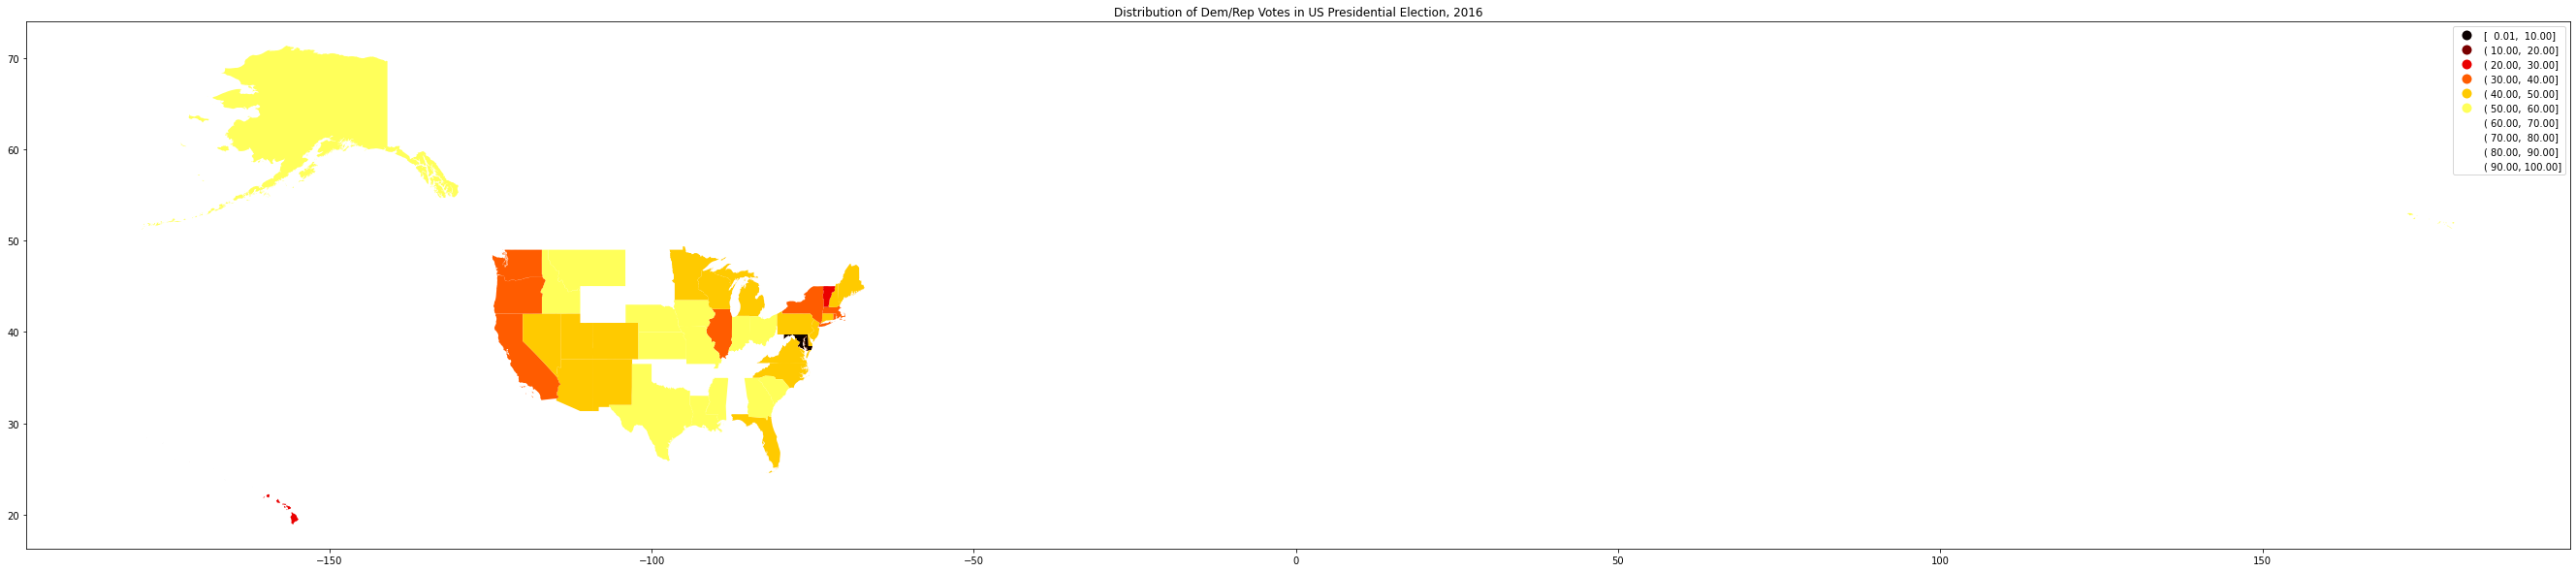

In [21]:
# choropleth maps

# define the figure and the legend
fig, ax = plt.subplots(figsize= (50, 10))

# plot with gdf
gdf_election_2016.plot(column = "percent_votes",
                       ax = ax,
                       legend = True,
                       cmap = "hot",
                       scheme = "User_Defined",
                       classification_kwds = dict(bins = [10, 20, 30, 40, 50, 60, 70,80,90,100]))

# add a title
plt.title("Distribution of Dem/Rep Votes in US Presidential Election, 2016")



## create a map with plotly express

In [22]:
# make a choropleth with plotly express

choropleth_election_2016 = px.choropleth(gdf_election_2016,
                                         locationmode = "USA-states",
                                         locations = "state_po",
                                         color = "percent_votes",
                                         color_continuous_scale = [(0, "blue"), (0.5, "purple"), (1, "red")],
                                         range_color = (0, 100),
                                         labels = {"state_po": "State", "percent_votes": "Percent Republican Votes"})

In [23]:
choropleth_election_2016.update_layout(geo_scope = "usa",
                                       title = "Distribution of Dem/Rep Votes in US Presidential Election, 2016")

# Choropleth Animation with Plotly Express

In [26]:
# preview gdf of election data
gdf_election.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party,writein,candidatevotes,totalvotes,version,notes,percent_votes
0,1,01779775,0400000US01,01,AL,Alabama,00,131174048583,4593327154,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",1976,Alabama,AL,1,63,41,US President,"Carter, Jimmy",democrat,False,659170,1182850,20171015,NaN,55.727269
1,1,01779775,0400000US01,01,AL,Alabama,00,131174048583,4593327154,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",1976,Alabama,AL,1,63,41,US President,"Ford, Gerald",republican,False,504070,1182850,20171015,NaN,42.614871
2,1,01779775,0400000US01,01,AL,Alabama,00,131174048583,4593327154,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",1976,Alabama,AL,1,63,41,US President,"Maddox, Lester",american independent party,False,9198,1182850,20171015,NaN,0.777613
3,1,01779775,0400000US01,01,AL,Alabama,00,131174048583,4593327154,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",1976,Alabama,AL,1,63,41,US President,"Bubar, Benjamin """"Ben""""",prohibition,False,6669,1182850,20171015,NaN,0.563808
4,1,01779775,0400000US01,01,AL,Alabama,00,131174048583,4593327154,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",1976,Alabama,AL,1,63,41,US President,"Hall, Gus",communist party use,False,1954,1182850,20171015,NaN,0.165194


In [25]:
# filter the data to include only republican votes
gdf_election_rep = gdf_election[gdf_election["party"] == "republican"]

In [27]:
#preview data
gdf_election_rep.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party,writein,candidatevotes,totalvotes,version,notes,percent_votes
1,1,01779775,0400000US01,01,AL,Alabama,00,131174048583,4593327154,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",1976,Alabama,AL,1,63,41,US President,"Ford, Gerald",republican,False,504070,1182850,20171015,NaN,42.614871
7,1,01779775,0400000US01,01,AL,Alabama,00,131174048583,4593327154,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",1980,Alabama,AL,1,63,41,US President,"Reagan, Ronald",republican,False,654192,1341929,20171015,NaN,48.750120
17,1,01779775,0400000US01,01,AL,Alabama,00,131174048583,4593327154,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",1984,Alabama,AL,1,63,41,US President,"Reagan, Ronald",republican,False,872849,1441713,20171015,NaN,60.542494
24,1,01779775,0400000US01,01,AL,Alabama,00,131174048583,4593327154,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",1988,Alabama,AL,1,63,41,US President,"Bush, George H.W.",republican,False,815576,1378476,20171015,NaN,59.165049
29,1,01779775,0400000US01,01,AL,Alabama,00,131174048583,4593327154,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",1992,Alabama,AL,1,63,41,US President,"Bush, George H.W.",republican,False,804283,1688060,20171015,NaN,47.645404


In [31]:
# make a choropleth with plotly express

choropleth_election_animation = px.choropleth(gdf_election_rep,
                                         locationmode = "USA-states",
                                         locations = "state_po",
                                         color = "percent_votes",
                                         color_continuous_scale = [(0, "blue"), (0.5, "purple"), (1, "red")],
                                         range_color = (0, 100),
                                         labels = {"state_po": "State", "percent_votes": "Percent Republican Votes"},
                                         animation_frame = "year")

choropleth_election_animation.update_layout(geo_scope = "usa",
                                       title = "Distribution of Dem/Rep Votes in US Presidential Election, 1976-2016")

## export the animation as a html file

In [32]:
# save as an html to share animation
choropleth_election_animation.write_html("chroropleth_us_prez_election_animation.html")

In [33]:
# download the file from google colab
files.download("chroropleth_us_prez_election_animation.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>